### Tabular-data Classification Pipeline

This notebook implements a comprehensive machine learning pipeline for binary classification, including data preprocessing, feature engineering, model training, and evaluation.

### Table of Contents
1. Data Loading and Initial Setup

2. Data Preprocessing

3. Feature Engineering

4. Model Training and Hyperparameter Tuning

5. Model Evaluation

---

### 1. Data Loading and Initial Setup

### Import Required Libraries

In [75]:
# Standard library imports
import os
from collections import Counter

# Third party library imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import RobustScaler, PowerTransformer
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.feature_selection import VarianceThreshold, SelectFromModel, SelectKBest, mutual_info_classif
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV

### Load Training and Test Data

<Axes: >

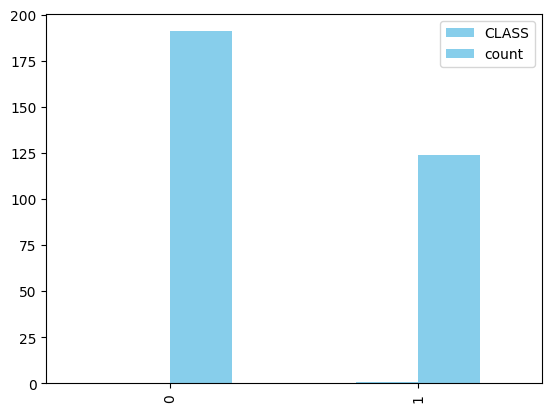

In [76]:
FILE_PATH = "../datasets/TASK_2/TASK_2/train_set.csv"
# Note: FILE_PATH should be defined before running this cell
# Load the training dataset
train_data = pd.read_csv(FILE_PATH)
train_labels = train_data['CLASS'].value_counts().reset_index()
train_labels.plot(kind="bar", color="skyblue")

<Axes: xlabel='CLASS'>

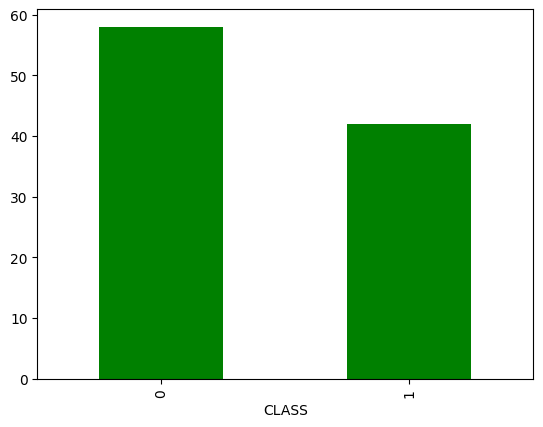

In [3]:
TEST_PATH = "../datasets/TASK_2/TASK_2/test_set.csv"
# Load the test dataset
# Note: TEST_PATH should be defined before running this cell
test_data = pd.read_csv(TEST_PATH)
test_labels = test_data['CLASS'].value_counts()
test_labels.plot(kind="bar", color="green")

In [4]:
# Separate features and target variable for test data
X_test = test_data.drop(columns=["ID", "CLASS"])        # Remove ID and target columns
y_test = test_data["CLASS"]                             # Extract target variable

In [5]:
# Separate features and target variable for training data
X_train = train_data.drop(columns=["ID", "CLASS"])      # Remove ID and target columns
y_train = train_data["CLASS"]                           # Extract target variable

<Axes: >

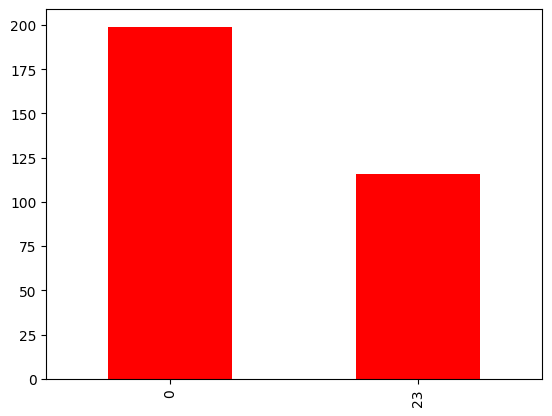

In [6]:
# Check for null values
missing_per_row = X_train.isna().sum(axis=1)
missing_per_row = missing_per_row.value_counts()
missing_per_row.plot(kind="bar", color="red")

<Axes: >

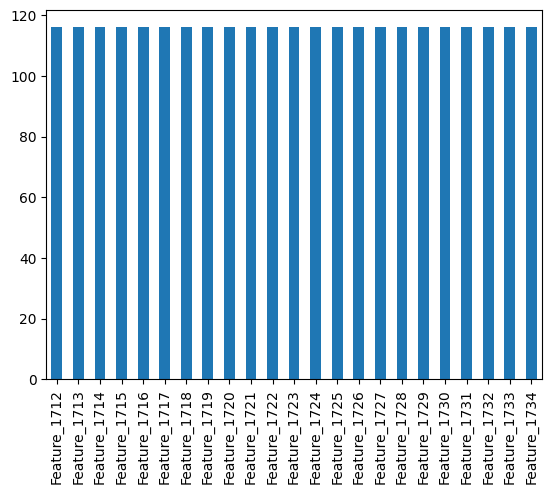

In [7]:
missing_per_column = X_train.isna().sum(axis=0)
missing_per_column = missing_per_column[missing_per_column > 0]
missing_per_column.plot(kind="bar")

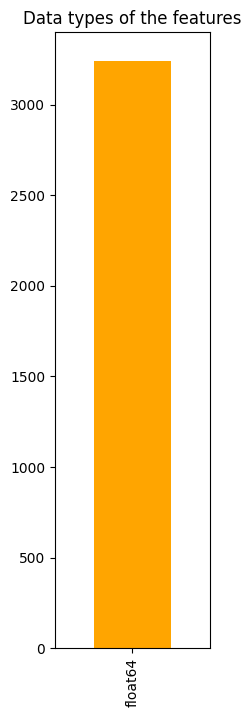

In [8]:
plt.figure(figsize=(2, 8))
feature_dtypes = X_train.dtypes.value_counts()
feature_dtypes.plot(kind="bar", color="orange")
plt.title("Data types of the features")
plt.show()

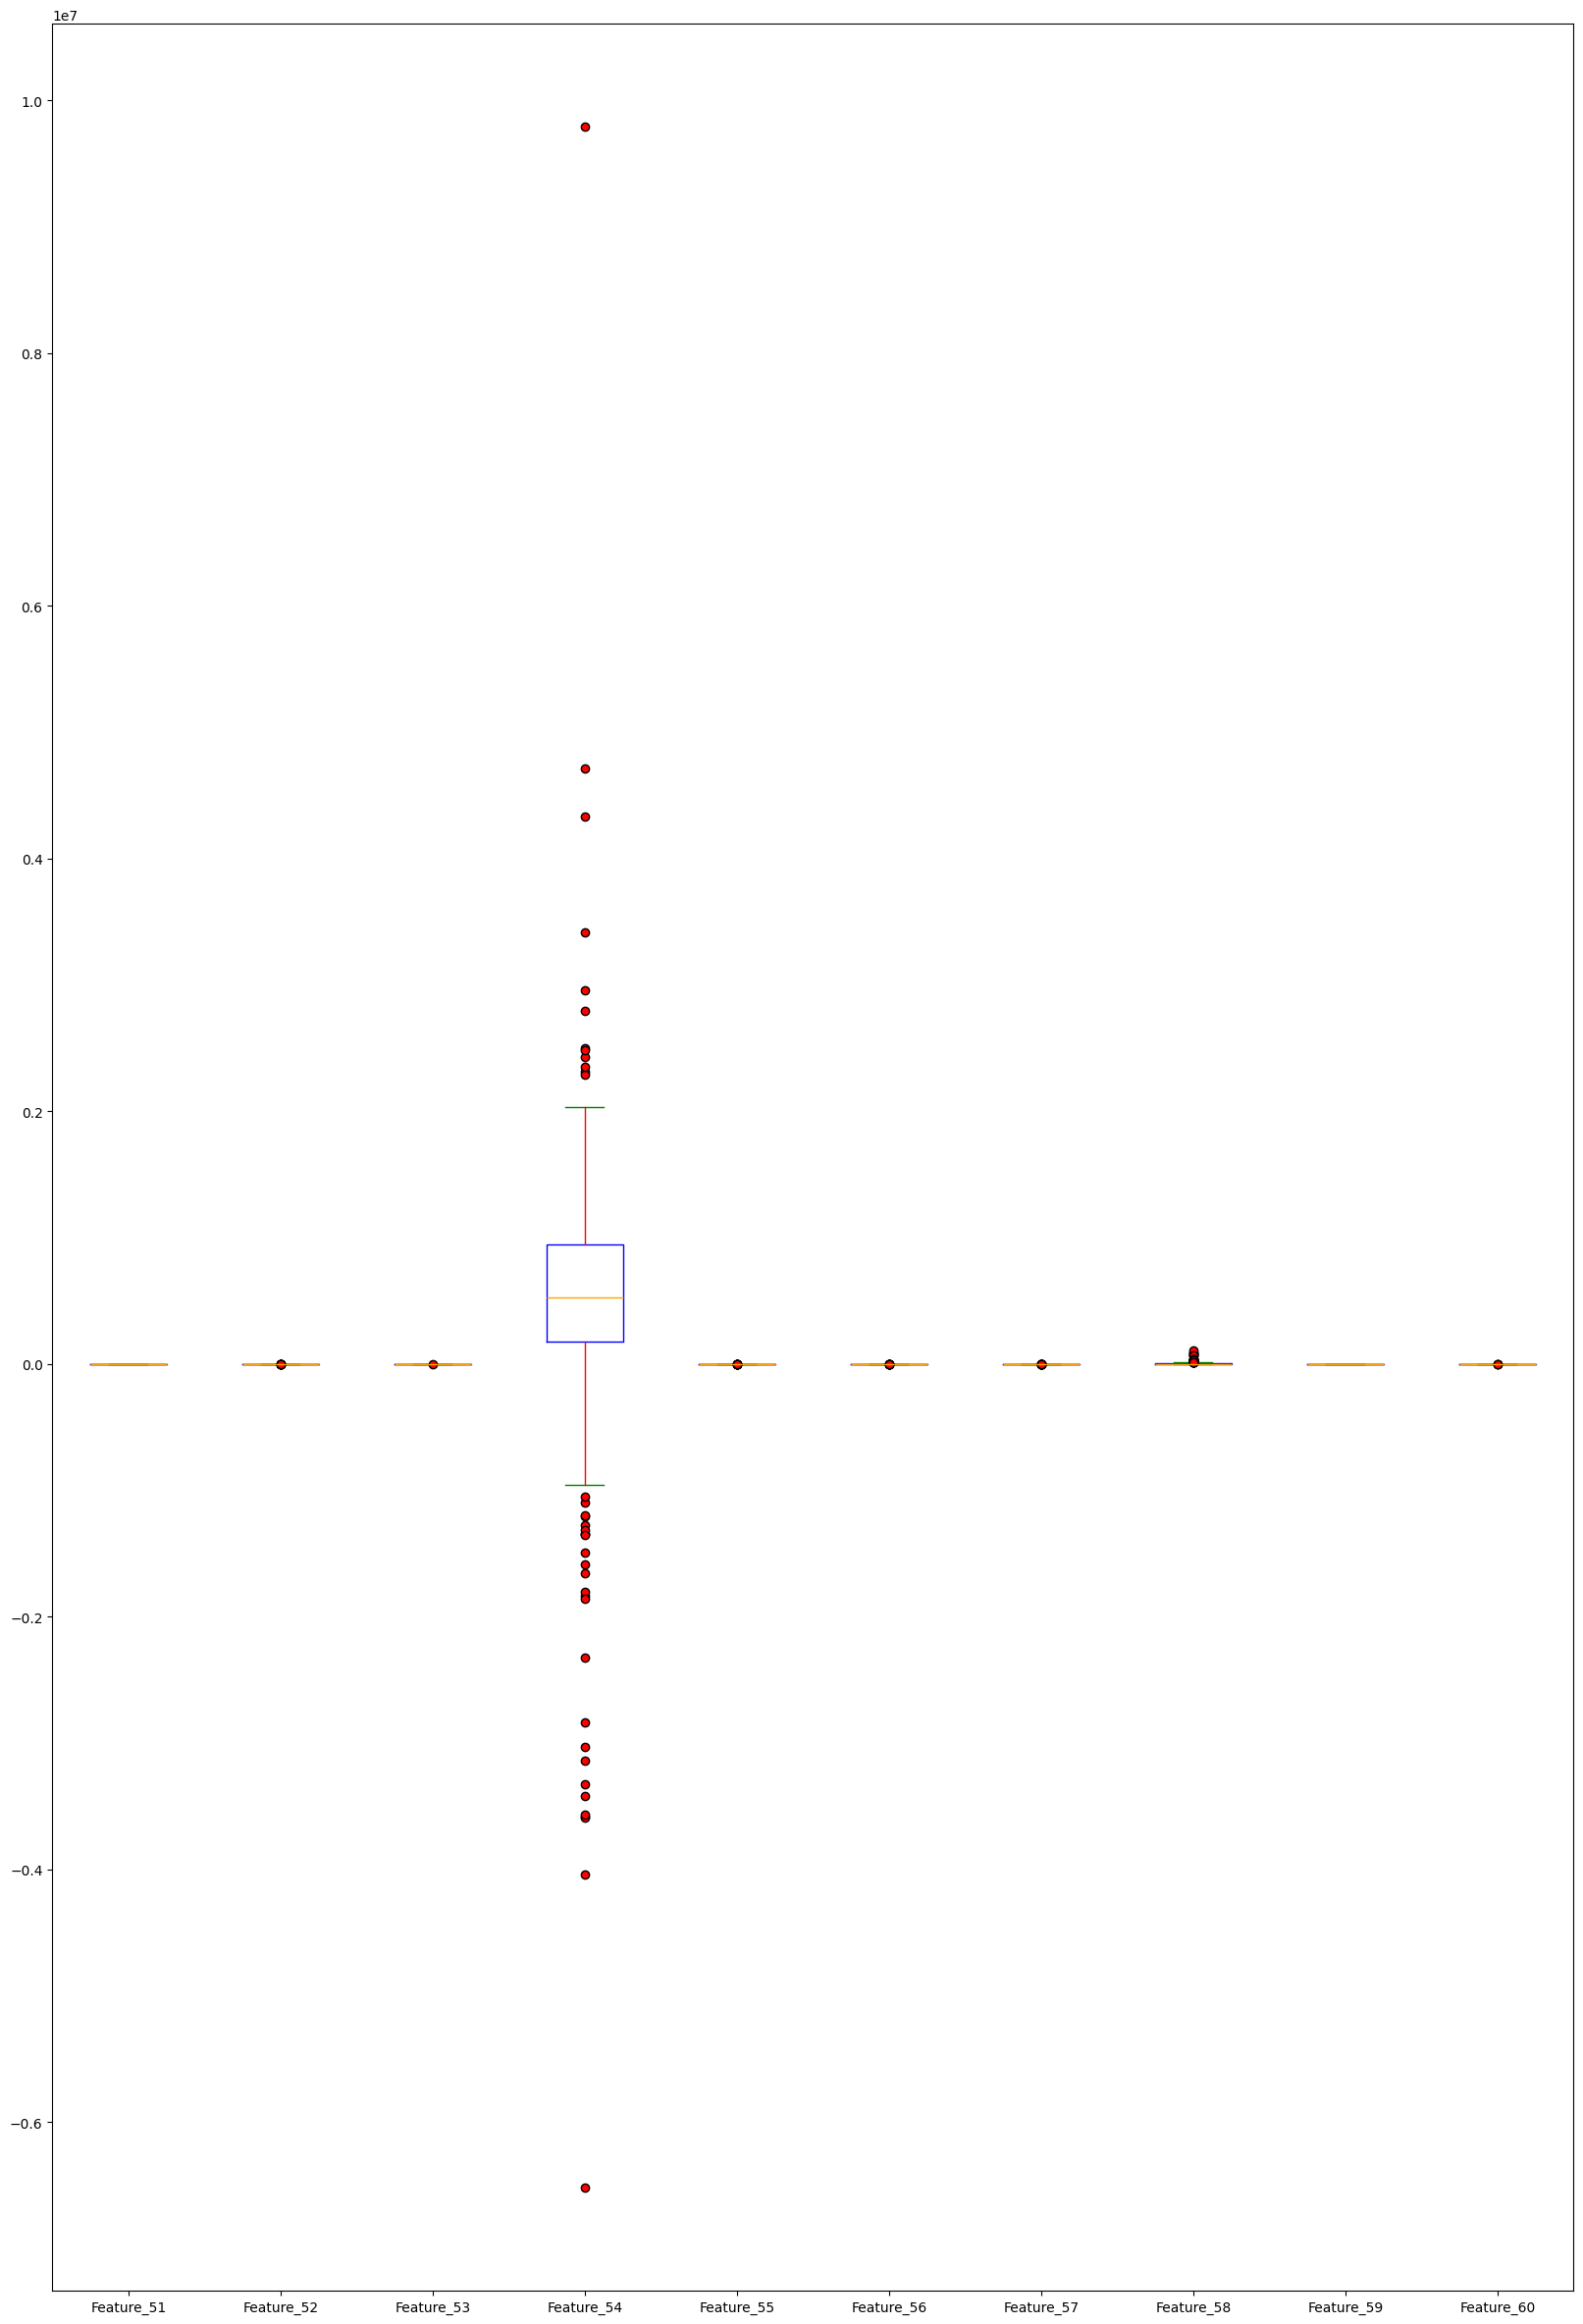

In [9]:
plt.figure(figsize=(20, 30))
plt.boxplot(X_train.iloc[:, 50:60], 
            positions=range(50, 60, 1), 
            tick_labels=X_train.iloc[:, 50:60].columns.to_list(),
            boxprops=dict(color='blue'), 
            whiskerprops=dict(color='red'), 
            capprops=dict(color='green'), 
            medianprops=dict(color='orange'), 
            flierprops=dict(markerfacecolor='red', marker='o'))
plt.show()

In [10]:
train_data.select_dtypes(include=['number']).columns

Index(['Feature_1', 'Feature_2', 'Feature_3', 'Feature_4', 'Feature_5',
       'Feature_6', 'Feature_7', 'Feature_8', 'Feature_9', 'Feature_10',
       ...
       'Feature_3230', 'Feature_3231', 'Feature_3232', 'Feature_3233',
       'Feature_3234', 'Feature_3235', 'Feature_3236', 'Feature_3237',
       'Feature_3238', 'CLASS'],
      dtype='object', length=3239)

In [11]:
train_dist= train_data["CLASS"].value_counts(normalize=True)
test_dist = test_data["CLASS"].value_counts(normalize=True)
dist_diff = abs(train_dist - test_dist).sum()
if dist_diff > 0.1:
    print(f"Warning: There is a large distribution difference: {dist_diff:.3f}")
else:
    print(f"Distribution difference is acceptable: {dist_diff:.3f}")


Distribution difference is acceptable: 0.053


In [12]:
y_train.isna().sum()

np.int64(0)

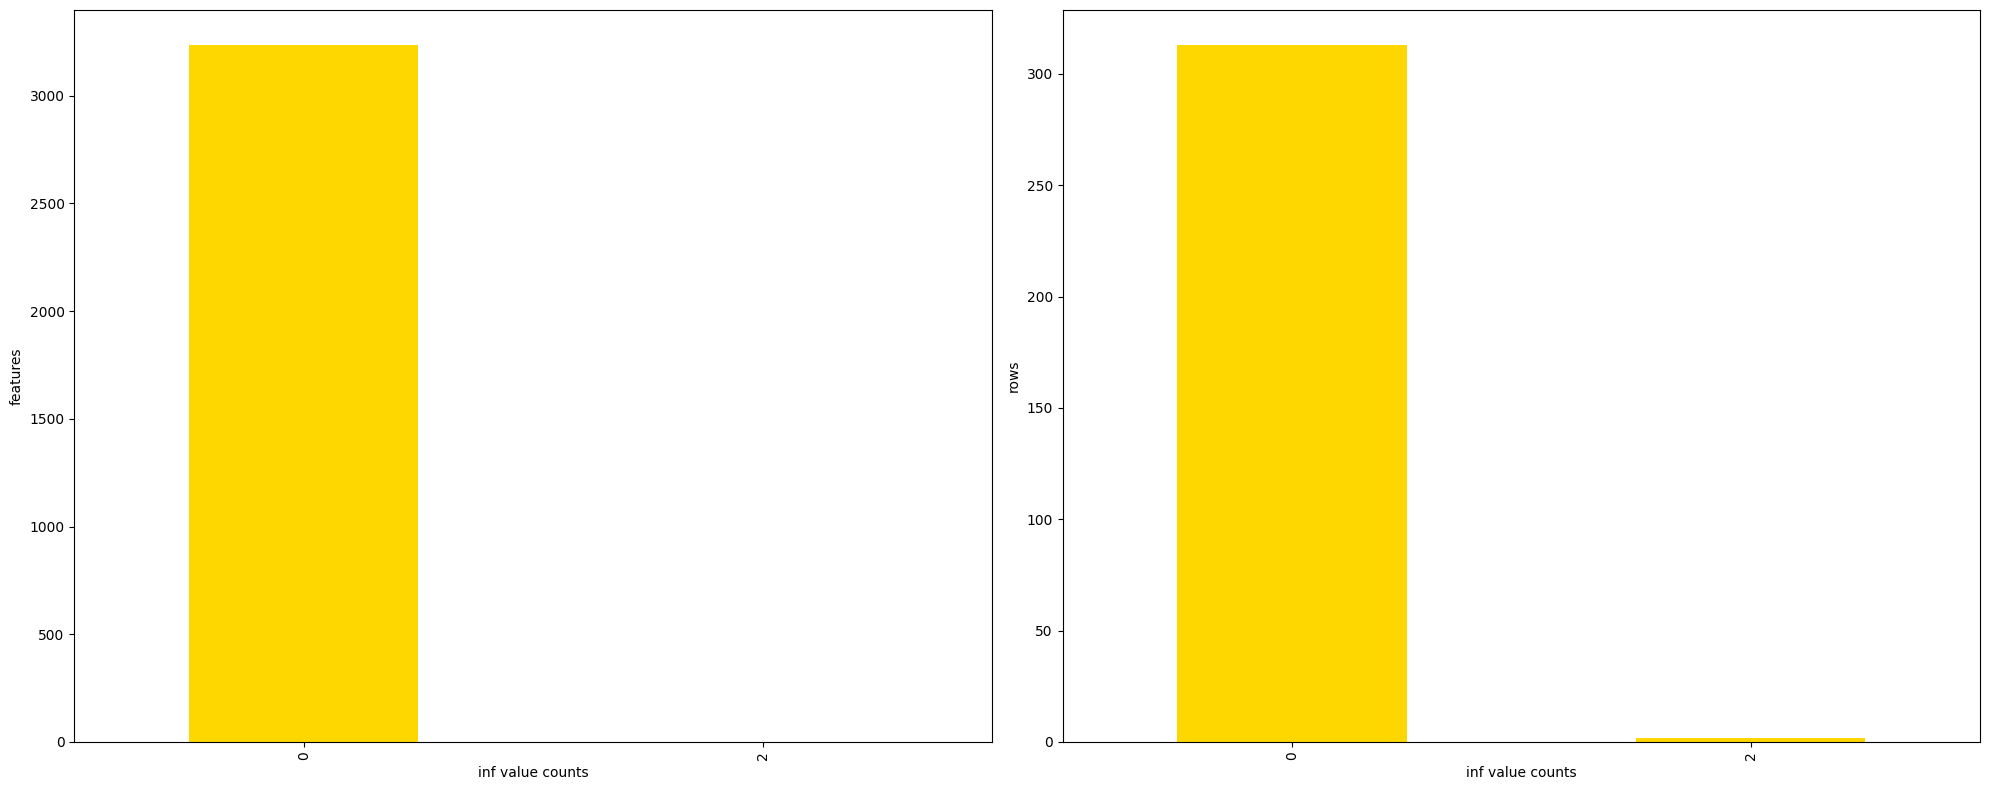

In [13]:
# Count infinities

fig, ax = plt.subplots(1, 2, figsize=(20, 8))

inf_per_feature = np.isinf(X_train).sum(axis=0).value_counts()
inf_per_feature.plot(kind="bar", color="gold", ax=ax[0])
ax[0].set_xlabel("inf value counts")
ax[0].set_ylabel("features")

inf_per_row = np.isinf(X_train).sum(axis=1).value_counts()
inf_per_row.plot(kind="bar", color="gold", ax=ax[1])
ax[1].set_xlabel("inf value counts")
ax[1].set_ylabel("rows")

plt.tight_layout()
plt.show()


<BarContainer object of 2 artists>

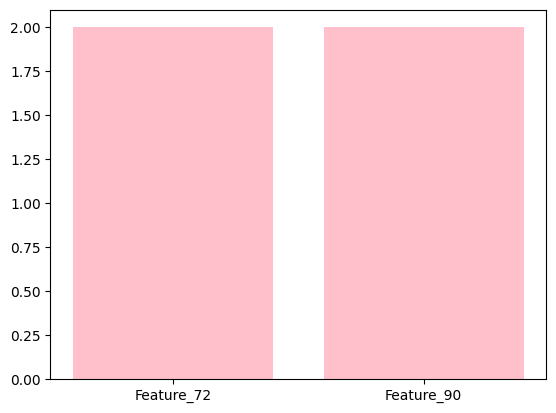

In [14]:
inf_mask = np.isinf(X_train)
inf_summary = inf_mask.sum(axis=0)
features = inf_summary[inf_summary > 0].index.to_list()
plt.bar(features, height=inf_summary[inf_summary > 0].values, color="pink")

### 2. Data Preprocessing

### Handle Infinite Values and Missing Data

In [15]:
# Replace infinite values with NaN for proper handling
# This prevents issues with algorithms that can't handle infinite values
X_train = X_train.replace([np.inf, -np.inf], np.nan)
X_test = X_test.replace([np.inf, -np.inf], np.nan)

In [ ]:
def visualize_feature(data):
    
    fig, axes = plt.subplots(1, 2, figsize=(10,4))
    sns.scatterplot(data, ax=axes[0])
    axes[0].set_title("Original feature")
    sns.boxplot(x=data, ax=axes[1])
    axes[1].set_title("Box plot")

    plt.tight_layout(pad=0.5)
    plt.show()


In [ ]:
# Impute missing values using K-Nearest Neighbors
# KNN imputation considers the similarity between samples to fill missing values

knn_imputer = KNNImputer(missing_values=np.nan, n_neighbors=10)
X_imputed = knn_imputer.fit_transform(X_train)              # Fit on training data and transform
Xt_imputed = knn_imputer.transform(X_test)                  # Only transform test data (no fitting)

In [18]:
# Convert back to DataFrame to maintain column names
X_imputed = pd.DataFrame(X_imputed, columns=X_train.columns)
Xt_imputed = pd.DataFrame(Xt_imputed, columns=X_test.columns)
feature_columns = X_imputed.columns

### Remove Low-Variance Features

In [19]:
# Remove features with very low variance (near-constant features)
# These features provide little to no information for classification
selector = VarianceThreshold(threshold=0.5)         # Features with variance < 0.5 will be removed
X_var = selector.fit_transform(X_imputed)           # Fit on training data and transform
Xt_var = selector.transform(Xt_imputed)             # Transform test data using same selector

print(f"Reduced from {X_imputed.shape[1]} to {X_var.shape[1]} features")

# Get the names of selected features
selected_mask = selector.get_support()
selected_features = [feature_columns[i] for i in range(len(selected_mask)) if selected_mask[i]]

# Convert back to DataFrame with proper column names
X_var = pd.DataFrame(X_var, columns=selected_features)
Xt_var = pd.DataFrame(Xt_var, columns=selected_features)


Reduced from 3238 to 1581 features


### Remove Highly Correlated Features

In [20]:
# Remove highly correlated features to reduce multicollinearity
# Highly correlated features provide redundant information

corr_matrix = X_var.corr().abs()            # Calculate absolute correlation matrix

# Get upper triangle of correlation matrix to avoid duplicates
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find features with correlation > 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

# Drop highly correlated features
X_uncorrelated = X_var.drop(columns=to_drop, axis=1)

In [21]:
uncorrelated_columns = X_uncorrelated.columns

In [22]:
Xt_uncorrelated = Xt_var.drop(columns=to_drop, axis=1)
Xt_uncorrelated

,Feature_1,Feature_3,Feature_10,Feature_11,Feature_13,Feature_14,Feature_27,Feature_55,Feature_57,Feature_58,...,Feature_3108,Feature_3124,Feature_3132,Feature_3137,Feature_3140,Feature_3156,Feature_3188,Feature_3204,Feature_3220,Feature_3236
0,15385.458333,6357.250488,3.165713,128.889395,17.482995,14.444362,6.184611e+05,32.561707,38.565819,517.733276,...,23.414174,49.823700,9.908382,96.682292,57.258646,62.372000,35.419265,31.969241,31.210169,29.952211
1,19539.729167,8168.700928,11.257600,137.432916,26.914001,15.199072,2.523413e+05,33.128307,13.300545,6377.843018,...,23.999956,56.183303,10.731481,132.357506,63.778178,59.465907,33.974920,33.372518,31.625858,31.625858
2,34867.125000,14382.916992,100.627321,247.727673,39.253779,22.395359,1.862830e+05,148.010773,5.342656,576.947876,...,23.332068,53.827111,11.942946,265.748546,67.636049,77.070013,34.608313,32.041778,31.065053,28.805248
3,46112.083333,16512.630859,8.614636,247.103217,45.856962,21.074495,-1.135713e+06,168.510284,-24.629391,4859.756836,...,21.408653,50.038946,9.320589,293.402995,63.254723,69.453816,31.587256,29.016363,27.601655,27.601655
4,37229.000000,12981.727539,10.869511,215.216170,28.984571,27.545766,-6.012861e+06,172.120468,-161.510132,80059.359375,...,21.247095,51.188984,21.437202,269.804796,57.835219,52.785143,32.217626,30.790878,28.207070,28.207070
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,41560.708333,16007.148438,26.477994,208.252251,30.902906,25.962195,-5.680349e+05,170.233109,-13.667595,4815.000977,...,22.910825,53.821157,15.418323,260.363740,67.802711,75.767988,33.736069,32.332433,30.470757,30.470757
96,47127.500000,15617.785156,23.197246,218.158199,35.586120,25.525543,1.558956e+06,63.255630,33.079544,594.851013,...,20.424048,43.433289,10.526057,289.256609,56.481908,55.534359,33.620432,30.983333,29.421751,28.104362
97,44099.625000,17311.683594,26.133394,286.567619,45.846735,19.225935,1.107357e+06,28.839373,25.110340,2325.000244,...,21.296958,43.308113,8.574055,260.916458,52.985252,61.402974,31.363993,28.836150,27.852157,27.051511
98,29193.833333,11772.097656,16.133637,222.139596,44.890517,14.535200,9.106550e+05,61.907932,31.193401,625.292603,...,23.066942,47.240634,10.064543,176.022897,54.409788,57.052240,31.971078,29.565275,28.454736,28.454736


### 3. Feature Engineering

### Outlier Detection and Treatment

In [23]:
# Define function to detect outliers using Interquartile Range (IQR) method
def detect_outliers_iqr(data):
    """
    Detect outliers using the IQR method.
    Values below Q1 - 1.5*IQR or above Q3 + 1.5*IQR are considered outliers.
    """
    Q1 = data.quantile(0.25)                        # First quartile
    Q3 = data.quantile(0.75)                        # Third quartile
    IQR = Q3 - Q1                                   # Interquartile range
    lower_bound = Q1 - 1.5 * IQR                    # Lower outlier threshold
    upper_bound = Q3 + 1.5 * IQR                    # Upper outlier threshold
    return (data < lower_bound) | (data > upper_bound)

In [24]:
# Define function to impute outliers with median values
def impute_outliers(data):
    """
    Replace outliers with the median value of each feature.
    This is a conservative approach that reduces the impact of extreme values.
    """
    temp = data.copy()
    for column in temp.columns:
        outliers = detect_outliers_iqr(temp[column])  # Detect outliers for this column
        median_value = temp[column].median()          # Calculate median for imputation
        temp.loc[outliers.to_list(), column] = median_value  # Replace outliers with median
    return temp

In [25]:
# Define function to clip outliers to acceptable range
def clip_outliers(data):
    """
    Clip outlier values to the IQR-based bounds.
    This preserves the relative ordering while reducing extreme values.
    """
    temp = data.copy()
    for column in temp.columns:
        Q1 = temp[column].quantile(0.25)
        Q3 = temp[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        temp[column] = np.clip(temp[column], lower_bound, upper_bound)
    return temp

In [26]:
# Apply outlier treatment: first impute, then clip
X_clipped = clip_outliers(impute_outliers(X_uncorrelated))
Xt_clipped = clip_outliers(impute_outliers(Xt_uncorrelated))

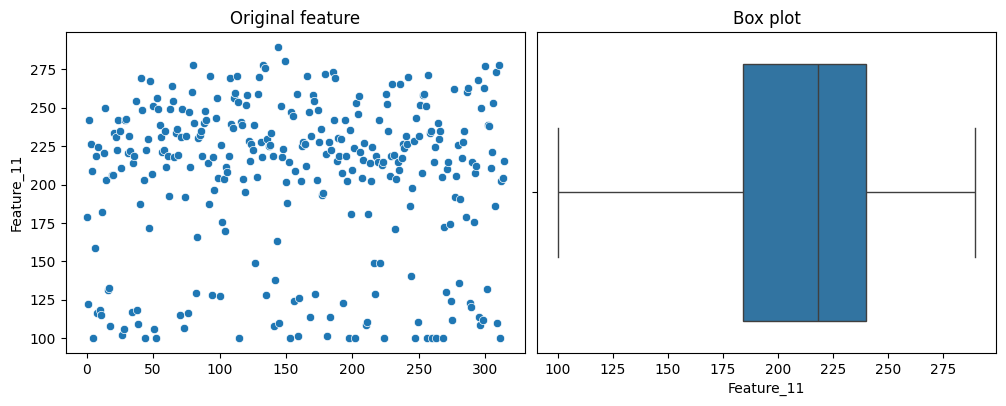

In [27]:
visualize_feature(X_clipped["Feature_11"])

In [ ]:
# Apply Yeo-Johnson power transformation to reduce skewness
# This transformation can handle both positive and negative values
pt = PowerTransformer(method='yeo-johnson')
X_transformed = pd.DataFrame(pt.fit_transform(X_clipped), columns=X_clipped.columns)
Xt_transformed = pd.DataFrame(pt.transform(Xt_clipped), columns=Xt_clipped.columns)


In [29]:
# Remove features that are still highly skewed after transformation
# Skewness > 0.75 indicates significant skewness
skewed_mask = abs(X_transformed.skew()) > 0.75
skewed_features = skewed_mask[skewed_mask == True].index.to_list()

# Drop skewed features
X_unskewed = X_transformed.drop(columns=skewed_features)
Xt_unskewed = Xt_transformed.drop(columns=skewed_features)

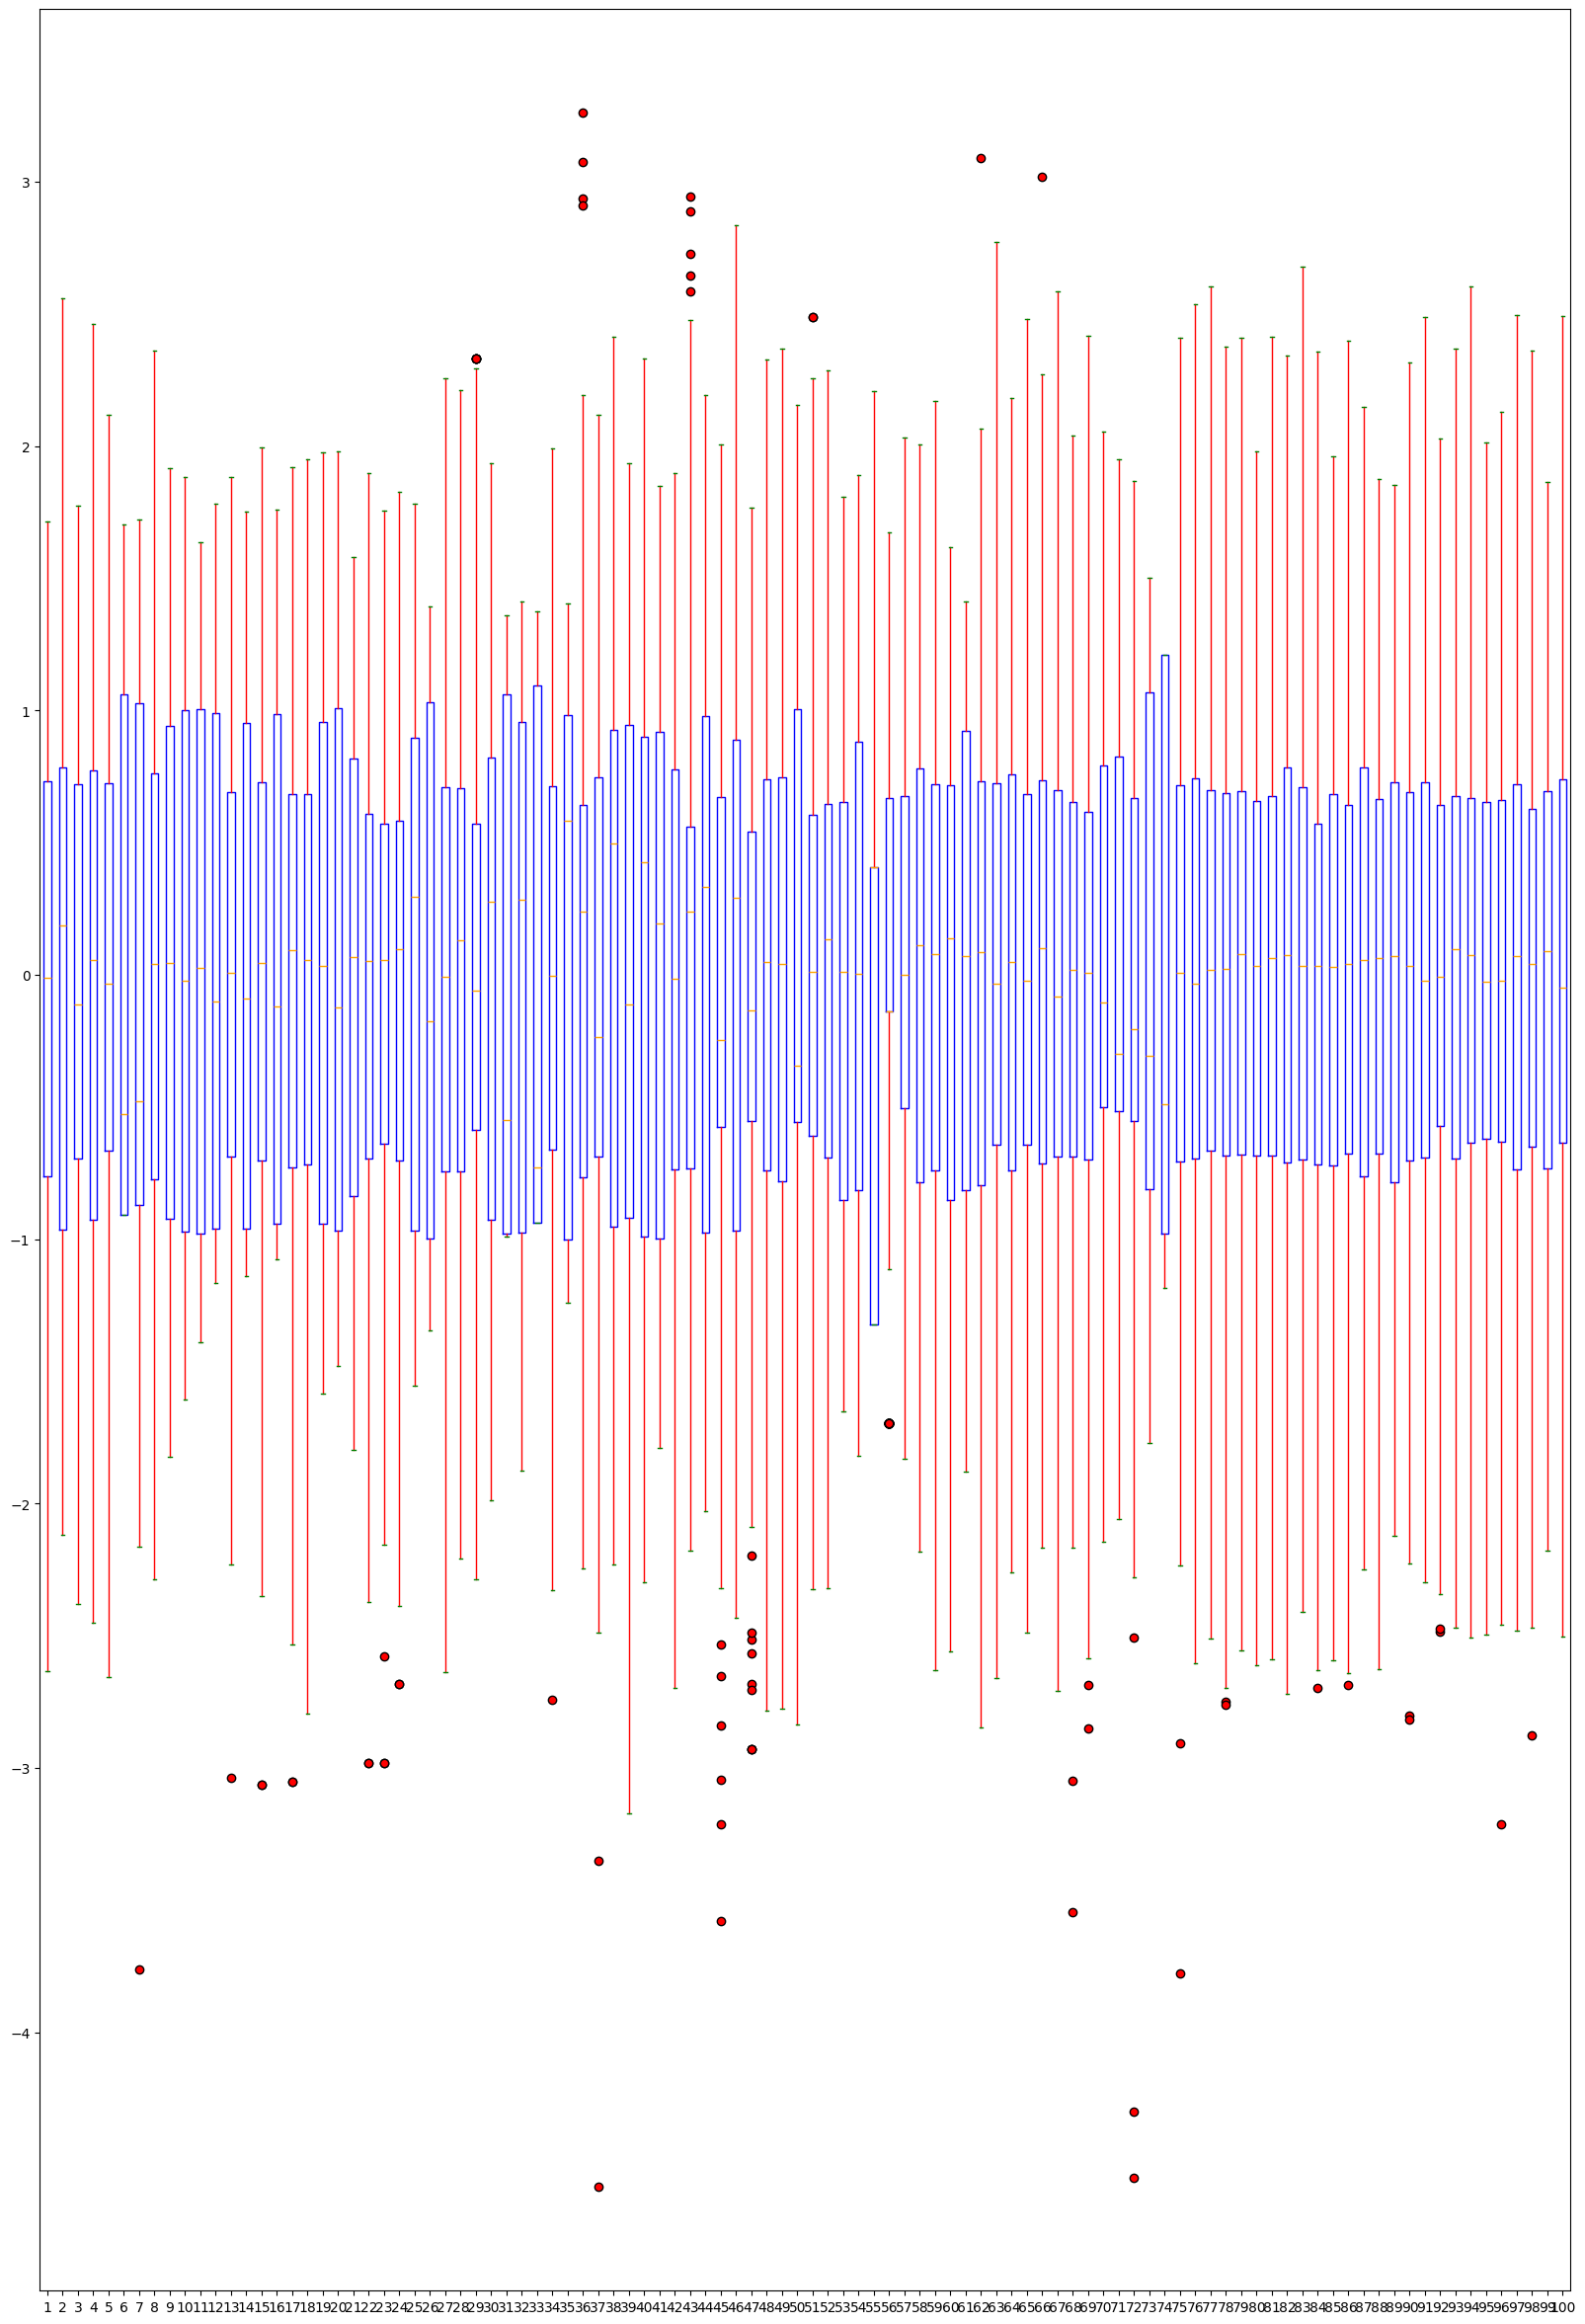

In [30]:
plt.figure(figsize=(20, 30))
plt.boxplot(X_unskewed.iloc[:, 100:200], 
            boxprops=dict(color='blue'), 
            whiskerprops=dict(color='red'), 
            capprops=dict(color='green'), 
            medianprops=dict(color='orange'), 
            flierprops=dict(markerfacecolor='red', marker='o'))
plt.show()

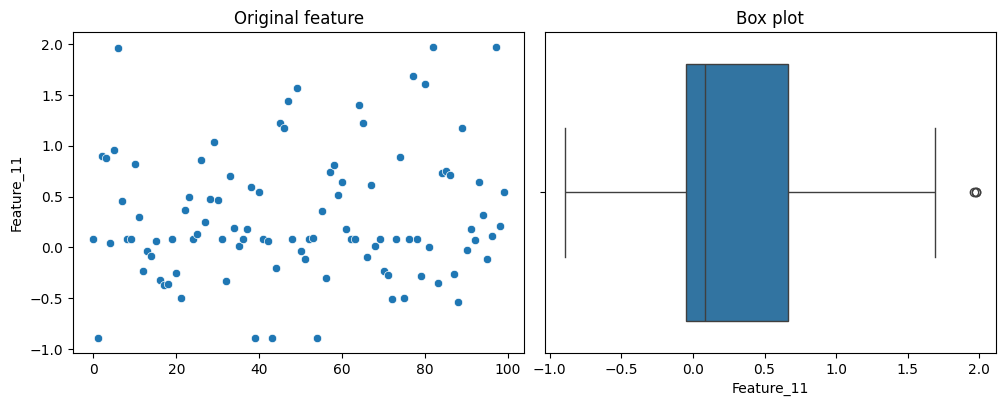

In [31]:
visualize_feature(Xt_unskewed["Feature_11"])

In [32]:
# Apply outlier treatment again after transformation
X_clean = clip_outliers(impute_outliers(X_unskewed))
Xt_clean = clip_outliers(impute_outliers(Xt_unskewed))

In [34]:
# Final check for skewness and remove any newly skewed features
# Using stricter threshold (1.0) for final cleaning
skewed_mask = abs(X_clean.skew()) > 1
skewed_features = skewed_mask[skewed_mask == True].index.to_list()
X_clean.drop(columns=skewed_features, inplace=True)
Xt_clean.drop(columns=skewed_features, inplace=True)

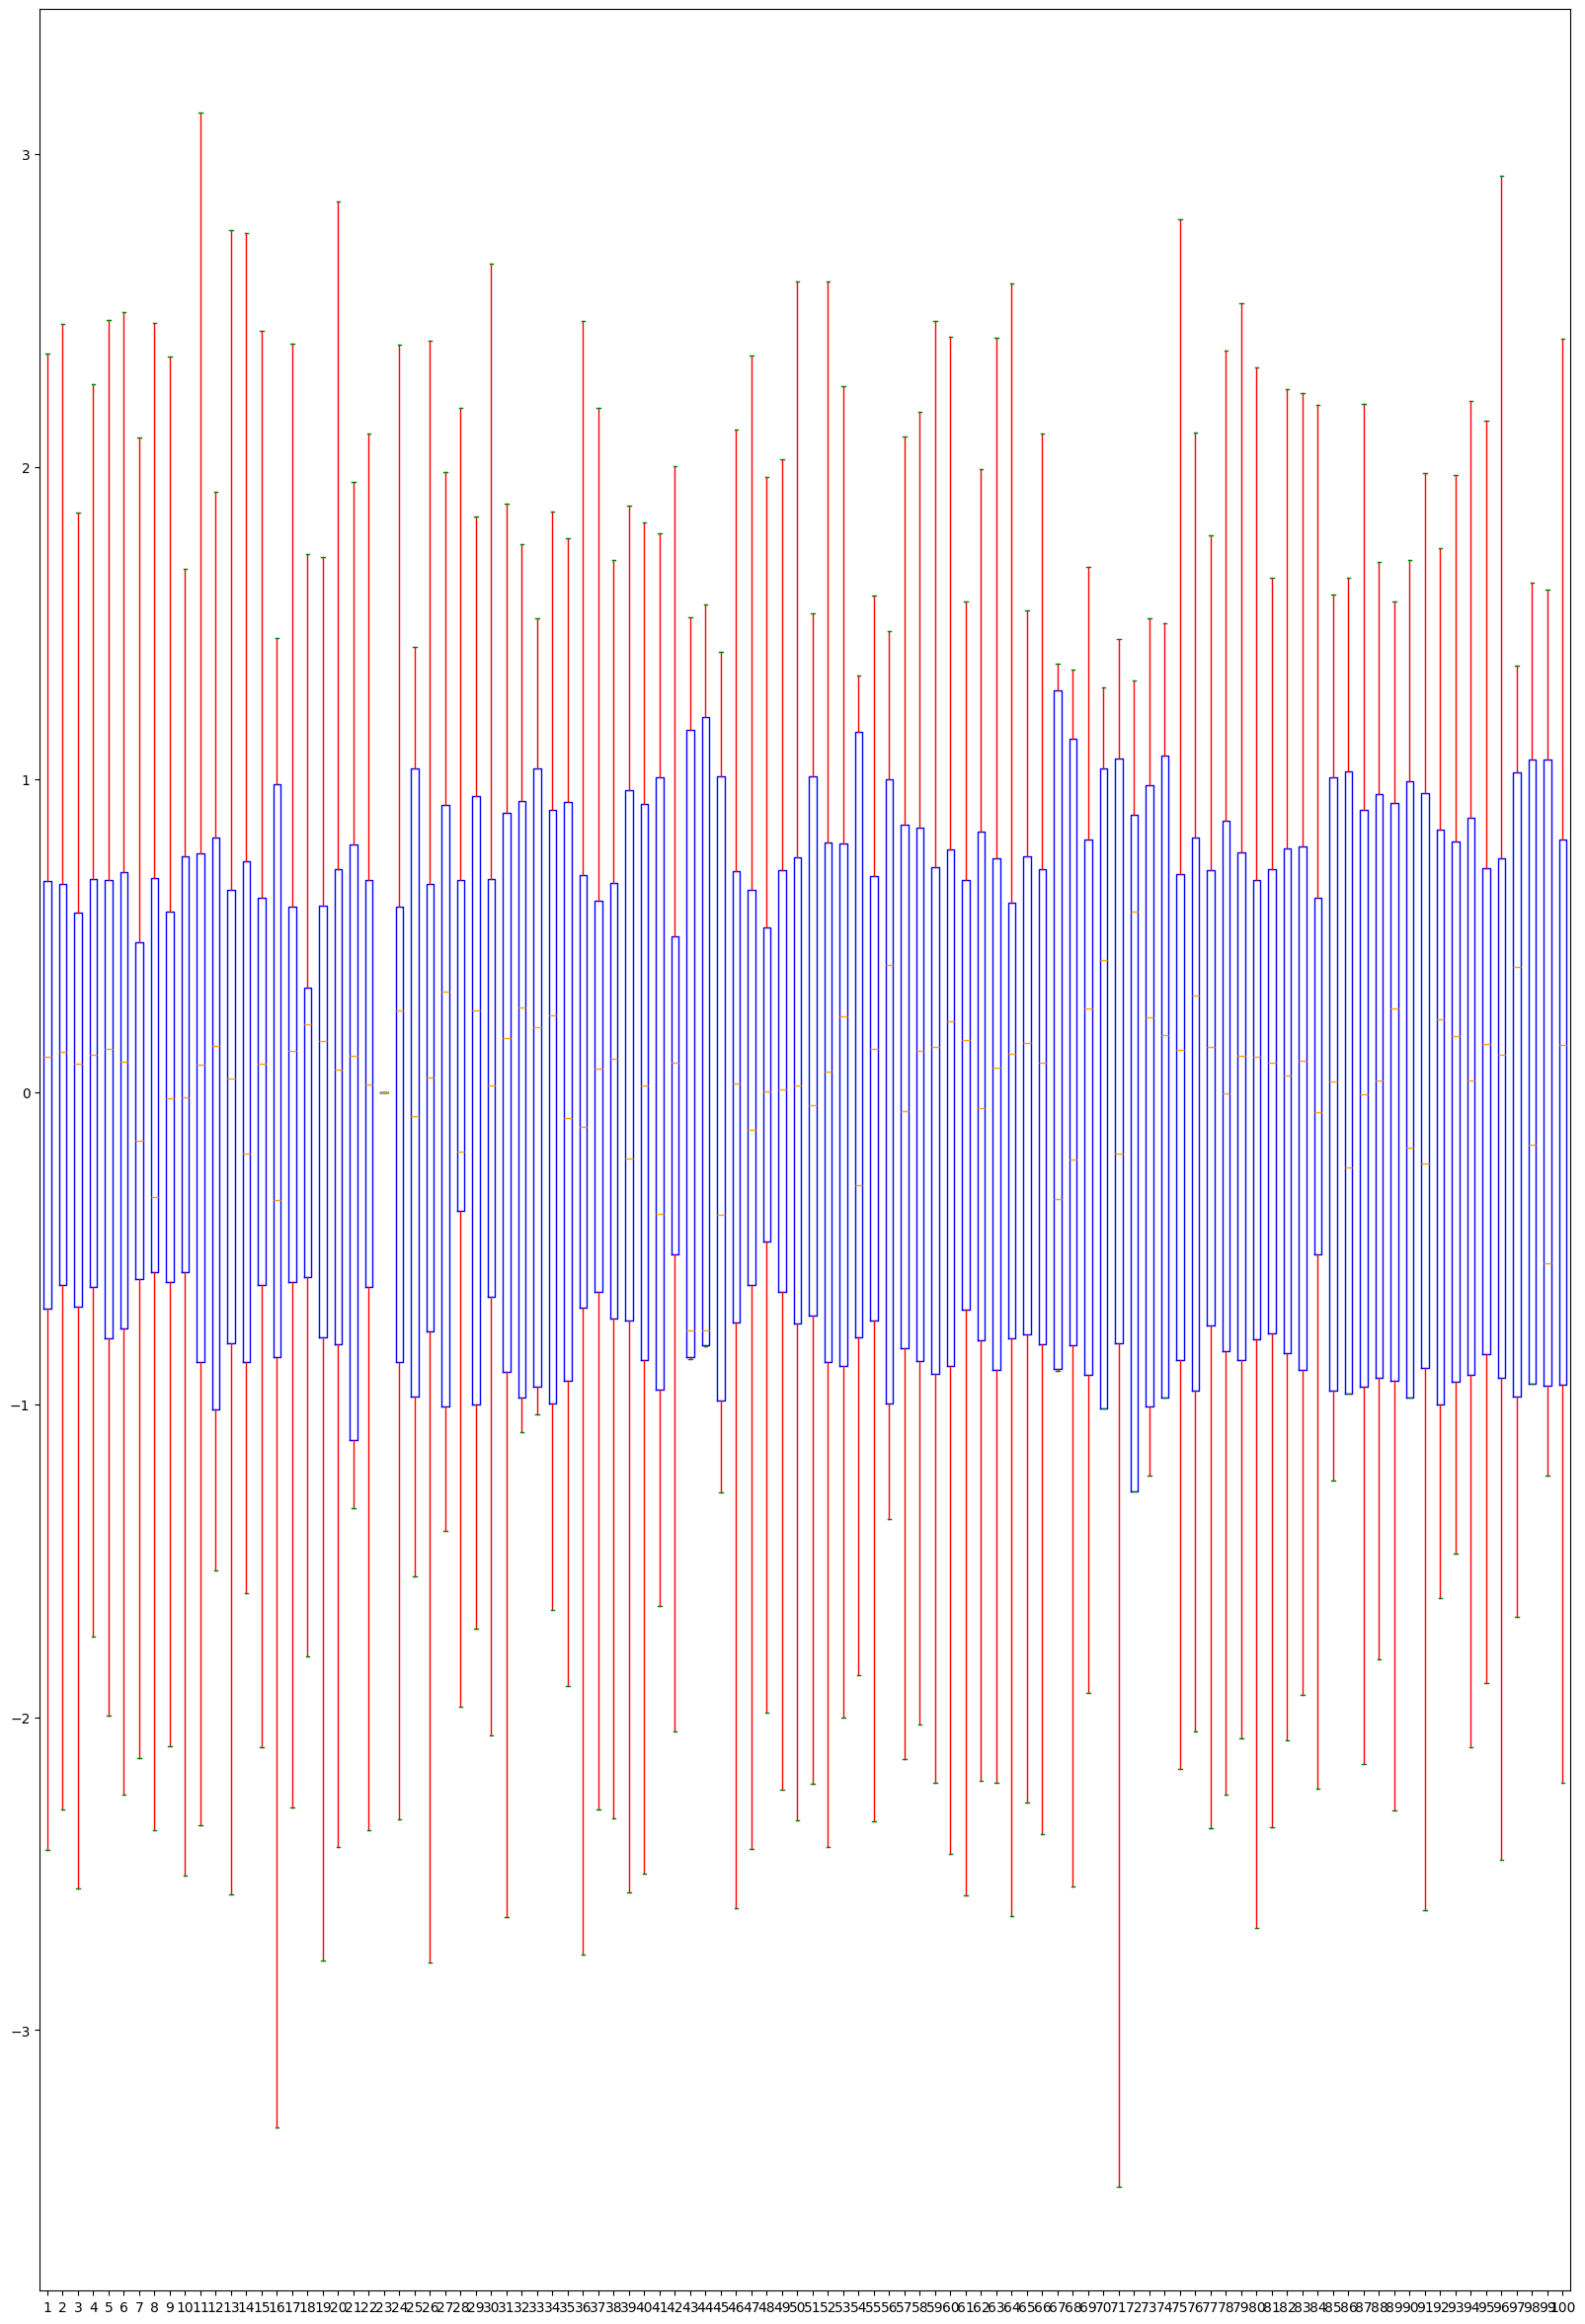

In [35]:
plt.figure(figsize=(20, 30))
plt.boxplot(X_clean.iloc[:, 0:100], 
            boxprops=dict(color='blue'), 
            whiskerprops=dict(color='red'), 
            capprops=dict(color='green'), 
            medianprops=dict(color='orange'), 
            flierprops=dict(markerfacecolor='red', marker='o'))
plt.show()

### Handle Class Imbalance with SMOTE


In [36]:
counter = Counter(y_train)
print('Before', counter)

# Apply SMOTE (Synthetic Minority Oversampling Technique) to handle class imbalance
# SMOTE generates synthetic examples of minority class to balance the dataset
smt = SMOTE(random_state=42)
X_sampled, y_sampled = smt.fit_resample(X_clean, y_train)

counter = Counter(y_sampled)
print('After', counter)


Before Counter({0: 191, 1: 124})
After Counter({0: 191, 1: 191})


### Feature Scaling

In [ ]:
# Scale features using RobustScaler
# RobustScaler is less sensitive to outliers compared to StandardScaler
scalar = RobustScaler()
X_scaled = scalar.fit_transform(X_sampled)          # Fit on training data and transform
Xt_scaled = scalar.transform(Xt_clean)              # Transform test data using same scaler

In [38]:
# scalar.data_max_, scalar.data_min_

In [39]:
# scalar.mean_, scalar.var_

In [40]:
# Convert back to DataFrame
X_scaled = pd.DataFrame(X_scaled, columns=X_clean.columns)
Xt_scaled = pd.DataFrame(Xt_scaled, columns=Xt_clean.columns)

In [41]:
mask = abs(X_scaled.skew()) > 1
mask[mask==True].sum() #Implies that there are no skewed features left

np.int64(0)

In [42]:
# Final outlier treatment after scaling
X_new = clip_outliers(impute_outliers(X_scaled))
Xt_new = clip_outliers(impute_outliers(Xt_scaled))

In [43]:
mask = abs(X_new.skew()) > 1
mask[mask == True].sum()

np.int64(0)

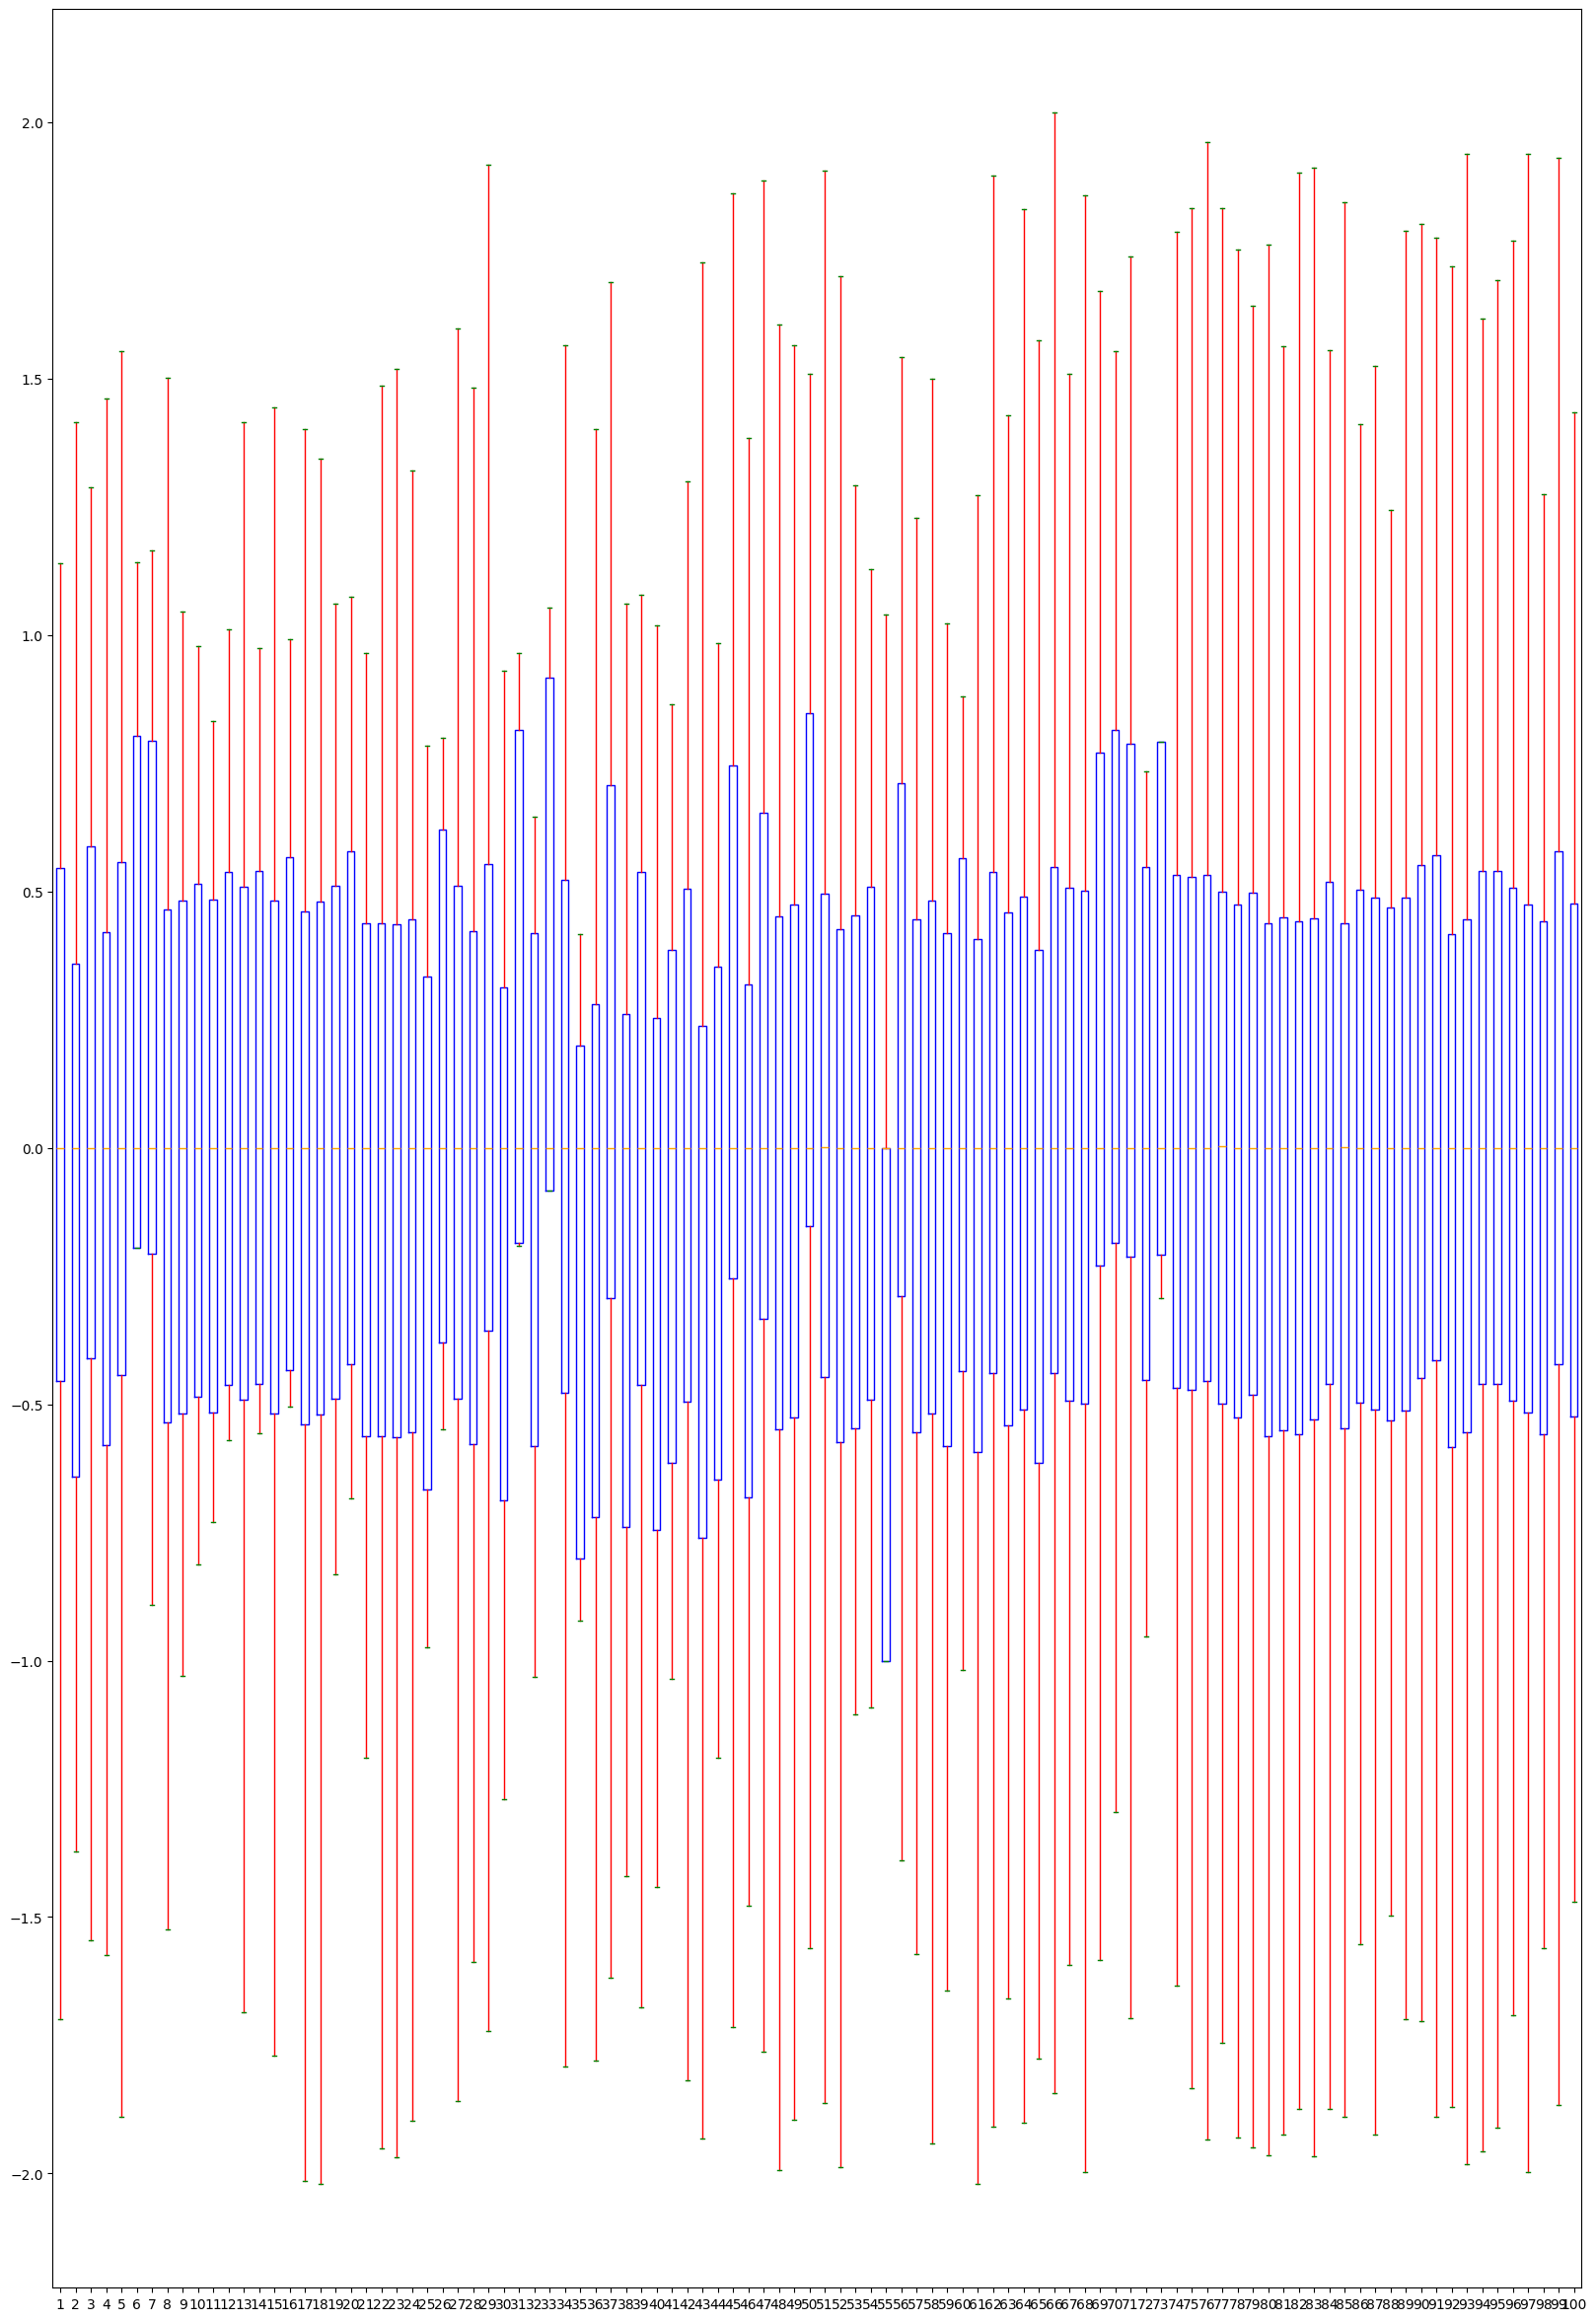

In [44]:
plt.figure(figsize=(20, 30))
plt.boxplot(X_new.iloc[:, 100:200], 
            boxprops=dict(color='blue'), 
            whiskerprops=dict(color='red'), 
            capprops=dict(color='green'), 
            medianprops=dict(color='orange'), 
            flierprops=dict(markerfacecolor='red', marker='o'))
plt.show()

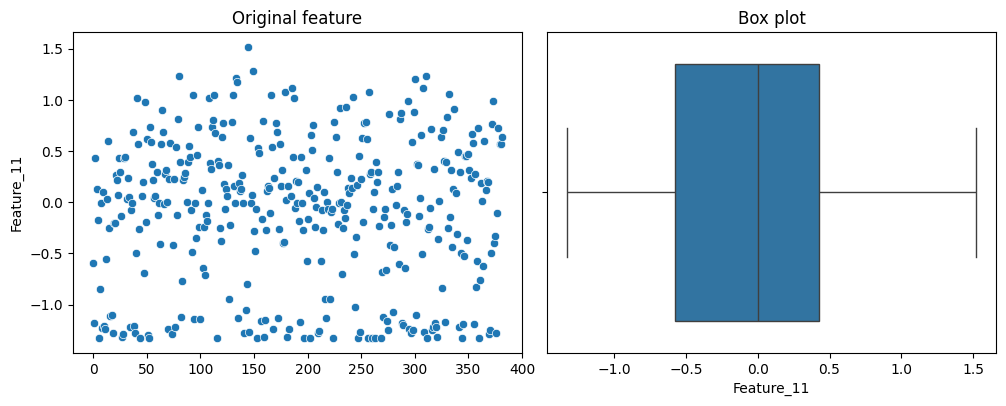

In [45]:
visualize_feature(X_new["Feature_11"])

(array([74., 10., 22., 38., 68., 67., 49., 31., 21.,  2.]),
 array([-1.32687859, -1.04231016, -0.75774172, -0.47317329, -0.18860486,
         0.09596358,  0.38053201,  0.66510044,  0.94966888,  1.23423731,
         1.51880574]),
 <BarContainer object of 10 artists>)

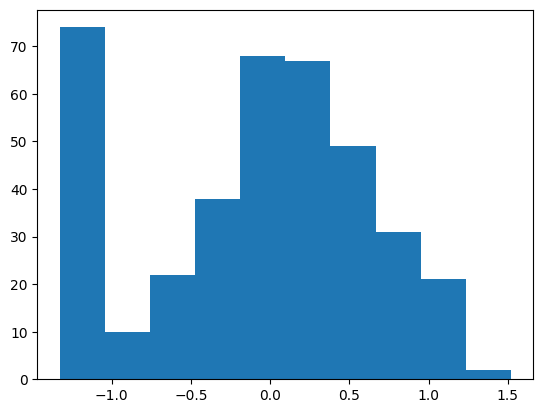

In [46]:
plt.hist(X_new["Feature_11"])

### Feature Selection

In [47]:
new_columns = X_new.columns

In [ ]:
# Select K best features using mutual information
# Mutual information measures the dependency between features and target
selector = SelectKBest(mutual_info_classif, k=10)   # Select top 10 features
X_kbest = selector.fit_transform(X_new, y_sampled)  # Fit on training data
Xt_kbest = selector.transform(Xt_new)               # Transform test data

# Get selected feature names
selected_mask = selector.get_support()
selected_kbest_features = [new_columns[i] for i in range(len(selected_mask)) if selected_mask[i]]

# Convert to DataFrame
X_kbest = pd.DataFrame(X_kbest, columns=selected_kbest_features)
Xt_kbest = pd.DataFrame(Xt_kbest, columns=selected_kbest_features)


In [49]:
kbest_columns = X_kbest.columns

In [ ]:
# Further feature selection using Random Forest feature importance
# This selects features based on their importance in a Random Forest model
clf_rf = RandomForestClassifier(n_estimators=50, random_state=42)
model = SelectFromModel(clf_rf)
model.fit(X_kbest, y_sampled)

# Transform both training and test sets
X_rfe = model.transform(X_kbest)
Xt_rfe = model.transform(Xt_kbest)

# Get final selected feature names
selected_mask = model.get_support()
selected_rfe_features = [kbest_columns[i] for i in range(len(selected_mask)) if selected_mask[i]]

In [51]:
# Convert to DataFrame with final feature set
X_rfe = pd.DataFrame(X_rfe, columns=selected_rfe_features)
Xt_rfe = pd.DataFrame(Xt_rfe, columns=selected_rfe_features)

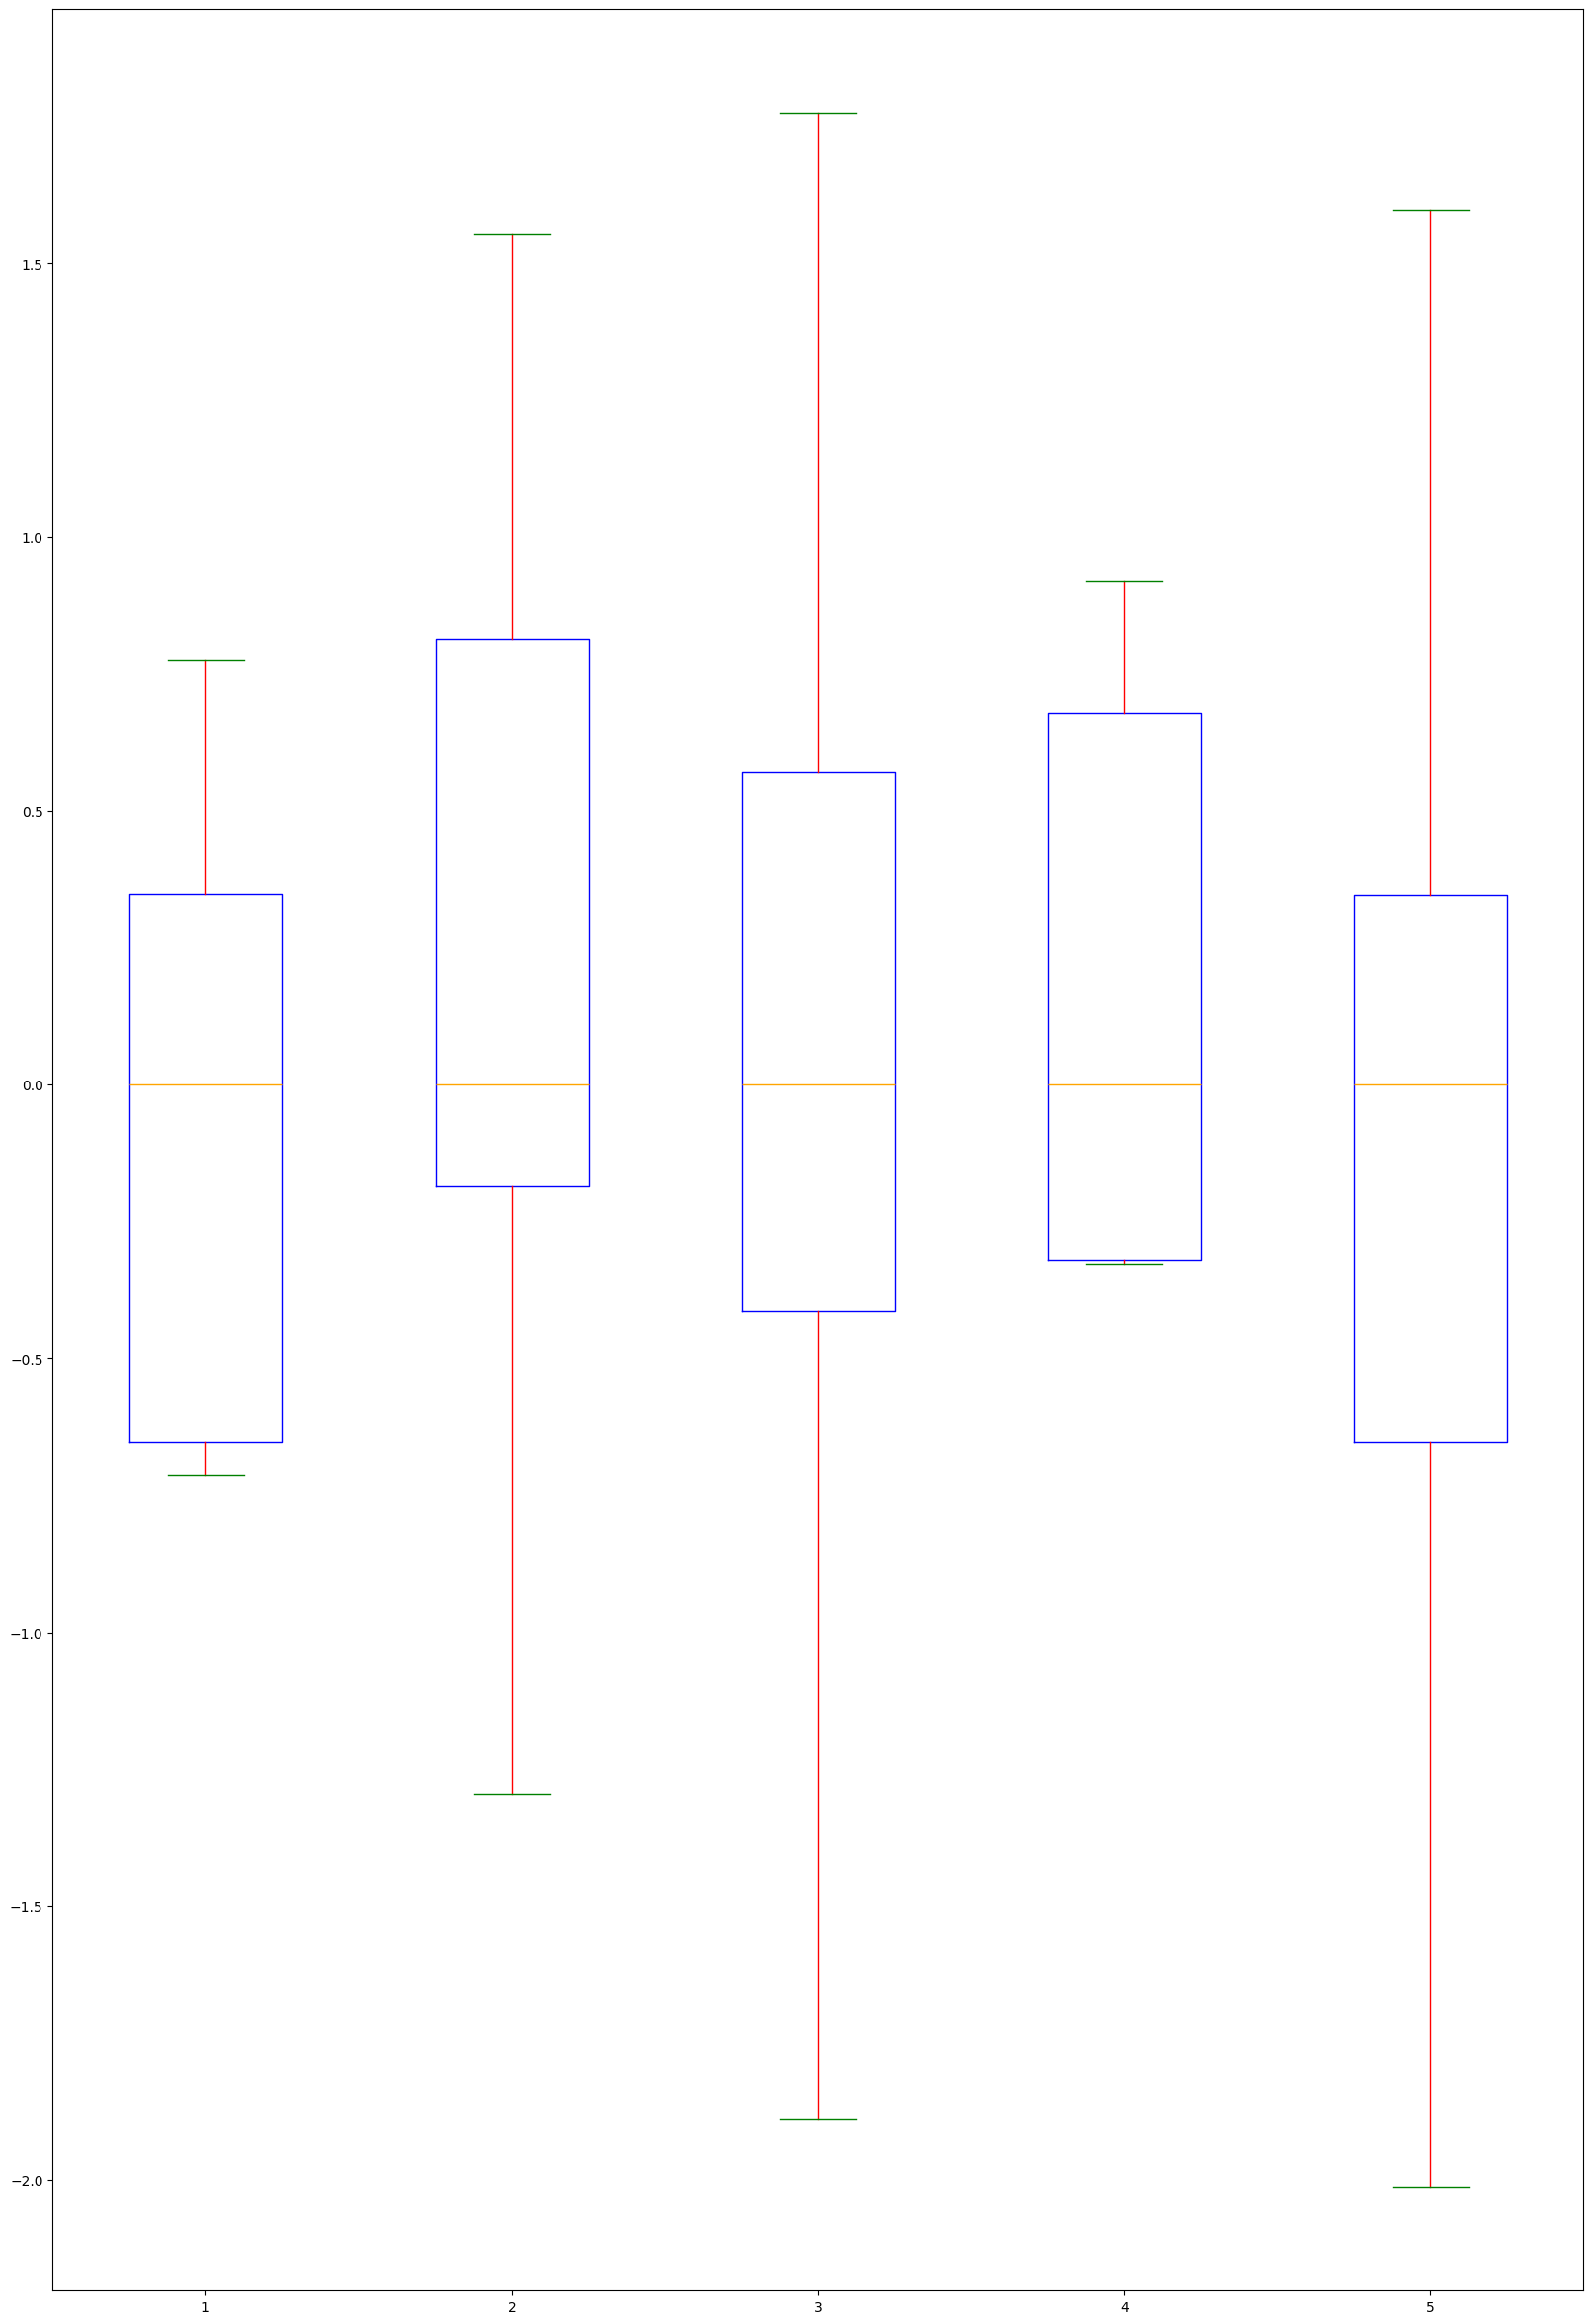

In [52]:
plt.figure(figsize=(20, 30))
plt.boxplot(X_rfe.iloc[:, :], 
            boxprops=dict(color='blue'), 
            whiskerprops=dict(color='red'), 
            capprops=dict(color='green'), 
            medianprops=dict(color='orange'), 
            flierprops=dict(markerfacecolor='red', marker='o'))
plt.show()

### 5. Model Training and Hyperparameter Tuning

### Model Configuration

In [ ]:
# Define models and their hyperparameter grids for grid search
models_config = {

    'Logistic Regression': {

        'model': LogisticRegression(random_state=42, max_iter=2000),
        'params': {
            'C': [0.01, 0.1, 1, 10, 100],              # Regularization strength
            'penalty': ['l1', 'l2'],                    # Regularization type
            'solver': ['liblinear', 'saga']             # Optimization algorithm
        }
    },

    'Random Forest': {

        'model': RandomForestClassifier(random_state=42, n_estimators=100),
        'params':{
            'n_estimators': [100, 200, 300],            # Number of trees
            'max_depth': [None, 5, 10, 20],             # Maximum depth of trees
            'min_samples_split': [2, 5, 10, 20],        # Min samples to split internal node
            'min_samples_leaf': [1, 2, 4, 8],           # Min samples in leaf node
            'max_features': ['sqrt', 'log2']            # Number of features for best split
        }
    },

    'Decision Tree': {

        'model': DecisionTreeClassifier(random_state=42),

        'params':  {
            'criterion': ['gini', 'entropy', 'log_loss'], # Split quality measure
            'max_depth': [5, 10, 20, 30],                 # Maximum depth of tree
            'min_samples_split': [2, 4, 8, 10],           # Min samples to split
            'min_samples_leaf': [1, 2, 3, 4],             # Min samples in leaf
            'max_features': [None, 'sqrt', 'log2'],       # Features to consider for split
        }

    }

}

In [156]:
models_config

{'Random Forest': {'model': RandomForestClassifier(random_state=42),
  'params': {'n_estimators': [100, 200, 300],
   'max_depth': [None, 5, 10, 20],
   'min_samples_split': [2, 5, 10, 20],
   'min_samples_leaf': [1, 2, 4, 8],
   'max_features': ['sqrt', 'log2']}}}

### Cross-Validation and Grid Search


In [ ]:
# Set up stratified k-fold cross-validation
# Stratified ensures each fold has the same proportion of each class
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Dictionary to store trained models and their performance
models = dict()

# Perform grid search for each model
for name, config in models_config.items():

    print(f"Training {name}...")
    # Grid search with cross-validation
    grid_search = GridSearchCV(
        estimator=config['model'], 
        param_grid=config['params'], 
        cv=cv,                      # Cross-validation strategy
        n_jobs=-1,                  # Use all available processors
        scoring='f1',               # Optimization metric (F1-score)
        verbose=0                   # Suppress detailed output
    )
    
    # Fit the grid search
    grid_search.fit(X_rfe, y_sampled)
    
    # Store the best model and its performance
    models[name] = {
        'model': grid_search.best_estimator_,    # Best model found
        'best_params': grid_search.best_params_, # Best hyperparameters
        'cv_score': grid_search.best_score_      # Best cross-validation score
    }   

    # Print results for this model
    if name in models: 
        print(f"Best CV Score: {models[name]["cv_score"]:.4f}")
        print(f"Best Parameters: {models[name]["best_params"]}")

Training Random Forest...
Best CV Score: 0.7343
Best Parameters: {'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}


### 6. Model Evaluation

### Evaluate All Models on Test Set

In [ ]:
# Dictionary to store test results for all models
results = {}

# Evaluate each trained model on the test set
for name, model_info in models.items():
    model = model_info['model']

    # Make predictions on test set
    y_pred = model.predict(Xt_rfe)
    # Get prediction probabilities (if available)
    y_pred_proba = model.predict_proba(Xt_rfe)[:, 1] if hasattr(model, 'predict_proba') else None

    # Calculate test accuracy
    accuracy = accuracy_score(y_test, y_pred)

    # Store results
    results[name] = {

        'accuracy': accuracy,
        'cv_score': model_info['cv_score'],
        'predictions': y_pred,
        'probabilities': y_pred_proba
    }

    # Print detailed results
    print(f"\n{name}:")
    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"CV Score: {model_info['cv_score']:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    



Random Forest:
Test Accuracy: 0.6000
CV Score: 0.7343

Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.71      0.67        58
           1       0.53      0.45      0.49        42

    accuracy                           0.60       100
   macro avg       0.58      0.58      0.58       100
weighted avg       0.59      0.60      0.59       100



### Individual Model Training and Evaluation

In [ ]:
# Train and evaluate Random Forest with specific parameters
print("=== RANDOM FOREST ===")
clf_rf = RandomForestClassifier(n_estimators=400)
clf_rf.fit(X_rfe, y_sampled)

y_pred_rf = clf_rf.predict(Xt_rfe)
print(confusion_matrix(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))


[[42 16]
 [25 17]]
              precision    recall  f1-score   support

           0       0.63      0.72      0.67        58
           1       0.52      0.40      0.45        42

    accuracy                           0.59       100
   macro avg       0.57      0.56      0.56       100
weighted avg       0.58      0.59      0.58       100



In [70]:
# Train and evaluate Logistic Regression with specific parameters
print("=== LOGISTIC REGRESSION ===")
clf_lr = LogisticRegression(max_iter=4085, C= 0.001, penalty='l2', solver='saga', class_weight="balanced", random_state=42)
clf_lr.fit(X_rfe, y_sampled)

y_pred_lr = clf_lr.predict(Xt_rfe)
print(confusion_matrix(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))

=== LOGISTIC REGRESSION ===
[[34 24]
 [19 23]]
              precision    recall  f1-score   support

           0       0.64      0.59      0.61        58
           1       0.49      0.55      0.52        42

    accuracy                           0.57       100
   macro avg       0.57      0.57      0.56       100
weighted avg       0.58      0.57      0.57       100



In [ ]:
# Train and evaluate Decision Tree with specific parameters
print("=== DECISION TREE ===")
clf_dt = DecisionTreeClassifier(criterion='gini', max_depth=20, max_features='sqrt', min_samples_leaf= 1, min_samples_split= 8)
clf_dt.fit(X_rfe, y_sampled)

y_pred_dt = clf_dt.predict(Xt_rfe)
print(confusion_matrix(y_test, y_pred_dt))
print(classification_report(y_test, y_pred_dt))


[[42 16]
 [22 20]]
              precision    recall  f1-score   support

           0       0.66      0.72      0.69        58
           1       0.56      0.48      0.51        42

    accuracy                           0.62       100
   macro avg       0.61      0.60      0.60       100
weighted avg       0.61      0.62      0.61       100



In [ ]:
# Check feature distributions

feature_drift_count = 0

for col in selected_rfe_features:
    train_mean = X_rfe[col].mean()
    test_mean = Xt_rfe[col].mean()
    train_std = X_rfe[col].std()

    if train_std > 0:
        z_score = (train_mean - test_mean) / train_std
        if z_score > 2:
            feature_drift_count += 1

if feature_drift_count > len(selected_rfe_features) * 0.2:
    print(f"Warning: {feature_drift_count} features show significant distribution drift")
else:
    print(f"Feature distributions look stable ({feature_drift_count} potential drift)")

In [ ]:
# Check for overfitting

for name, model_info in models.items():
    model = model_info['model']
    train_pred = model.predict(X_rfe)
    train_acc = accuracy_score(y_sampled, train_pred)

    test_pred = model.predict(Xt_rfe)
    test_acc = accuracy_score(y_test, test_pred)

    overfitting = abs(train_acc - test_acc)
    print(f"{name}: Train Accuracy: {train_acc:.3f}, Test Accuracy: {test_acc:.3f}, Overfitting: {overfitting:.3f}")

    if overfitting > 0.1:
        print(f"Potential overfitting detected for {name} model")

In [ ]:
clf = DecisionTreeClassifier(random_state=42)
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
scores = cross_val_score(clf, X_rfe, y_train, cv=kf, scoring="accuracy")

## Summary

This notebook implements a complete machine learning pipeline that includes:

1. **Data Preprocessing**: Handling missing values, infinite values, and basic data cleaning
2. **Feature Engineering**: Outlier treatment, power transformations, and skewness reduction
3. **Feature Selection**: Variance thresholding, correlation analysis, mutual information, and model-based selection
4. **Class Balancing**: SMOTE oversampling to handle imbalanced datasets
5. **Model Training**: Grid search with cross-validation for hyperparameter optimization
6. **Model Evaluation**: Comprehensive evaluation using multiple metrics

The pipeline is designed to be robust and handles common data quality issues that arise in real-world datasets.